# PyGIMLi - Electrical Resistivity Tomography

Using the ERT solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve the corresponding inverse problem.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/pygimli_ert/archived/pygimli_ert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
# !MINICONDA_PREFIX=/usr/local
# !wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
# !chmod +x $MINICONDA_INSTALLER_SCRIPT
# !./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX
# !conda install -c gimli pygimli -y

# import sys
# _ = (sys.path.append("/usr/local/lib/python3.7/site-packages"))

We will need the following packages:

- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

Additionally, we wrap some `pygimli` code in file `pygimli_ert_lib.py` and import it
here for conciseness.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

from cofi import BaseProblem, InversionOptions, Inversion

from pygimli_ert_lib import *

np.random.seed(42)

## 1. Define the problem

We first define the true model, the survey and map it on a computational mesh designed for the survey and true anomaly.

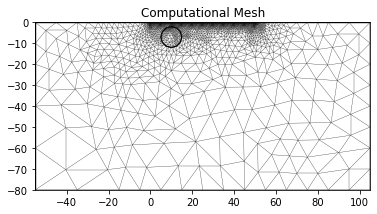

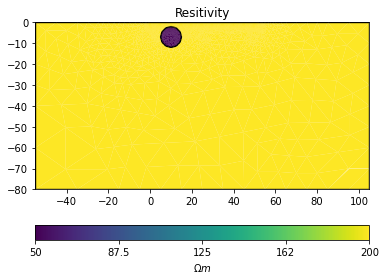

In [3]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = scheme_fwd()
geometry = geometry_true()
fmesh = mesh_fwd(scheme, geometry)
rhomap = markers_to_resistivity()
model_true = model_vec(rhomap, fmesh)

# plot the compuational mesh and the true model
ax=pg.show(fmesh)
ax[0].set_title("Computational Mesh")
ax=pg.show(fmesh,data=model_true,label=r"$\Omega m$")
ax[0].set_title("Resitivity");

Generate the synthetic data as a container with all the necessary information for plotting.

22/06/22 - 13:47:32 - pyGIMLi - INFO - Calculate geometric factors.


ModellingBase::setMesh() copying new mesh ... Found datafile: 51 electrodes
Found: 51 free-electrodes
rMin = 0.5, rMax = 100
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.093 s
FOP updating mesh dependencies ... 0 s
Obtaining geometric factors (analytical)


Calculating response for model: min = 50 max = 200
Allocating memory for primary potential...... 0.009

No primary potential for secondary field calculation. Calculating analytically...
Factorize (Cholmod) matrix ... 0.031
Factorize (Cholmod) matrix ... 0.028
Factorize (Cholmod) matrix ... 0.027
Factorize (Cholmod) matrix ... 0.028
Factorize (Cholmod) matrix ... 0.027
Factorize (Cholmod) matrix ... 0.027
Factorize (Cholmod) matrix ... 0.028
Factorize (Cholmod) matrix ... 0.027
Factorize (Cholmod) matrix ... 0.029
Factorize (Cholmod) matrix ... 0.03
Factorize (Cholmod) matrix ... 0.029
Factorize (Cholmod) matrix ... 0.029
Factorize (Cholmod) matrix ... 0.028
Factorize (Cholmod) matrix ... 0.028
Factorize (Cholmod) matrix ... 0.028
Factorize (Cholmod) matrix ... 0.028
Factorize (Cholmod) matrix ... 0.026
Forward: time: 0.942s
Response: min = 99.3719 max = 218.992 mean = 174.083
Reciprocity rms(modelReciprocity) 0.255153%, max: 1.53835%


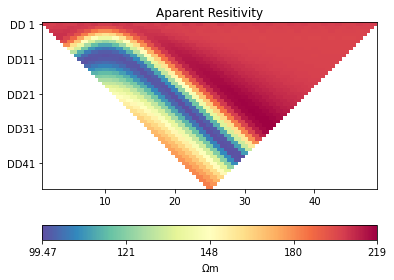

In [4]:
# PyGIMLi - generate data
survey = ert.simulate(fmesh, res=rhomap, scheme=scheme)

ax=ert.showERTData(survey,label=r"$\Omega$m")
ax[0].set_title("Aparent Resitivity")

y_obs = np.log(survey['rhoa'].array())

The inversion can use a different mesh and the mesh to be used should know nothing about the mesh that was designed based on the true model. We wrap two kinds of mesh as examples in the library code `pygimli_ert_lib.py`, namely triangular and rectangular mesh.

Use `imesh_tri = mesh_inv_triangular(scheme)` to initialise a triangular mesh, with the following optional arguments and corresponding default values:

- `start=[-15, 0]`
- `end=[65, -30]`

Use `imesh_rect = mesh_inv_rectangular()` to initislise a rectangular mesh, with the following optional arguments and corresponding default values:

- `x_start=-15`
- `x_stop=60`
- `x_num=11`
- `y_start=-30`
- `y_stop=0`
- `y_num=5`

Here we first demonstrate how to use a *triangular mesh*. Note that this makes the inversion problem under-determined.

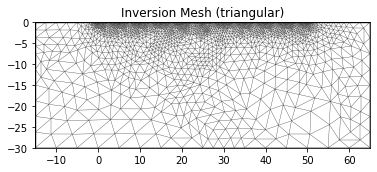

In [5]:
# PyGIMLi - quick demo of triangular mesh
imesh_tri = mesh_inv_triangular(scheme)

ax=pg.show(imesh_tri)
ax[0].set_title("Inversion Mesh (triangular)");

Check [here](https://github.com/inlab-geo/cofi-examples/tree/main/examples/pygimli_ert)
for inversion examples using triangular mesh.

For the purpose of this notebook, we use a *rectangular mesh* for a simple demonstration.

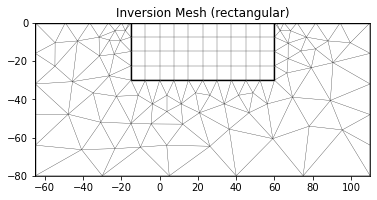

In [6]:
# PyGIMLi - create mesh for inversion
imesh = mesh_inv_rectangular()
ax = pygimli.show(imesh)
ax[0].set_title("Inversion Mesh (rectangular)");

With the inversion mesh created, we now define a starting model, forward operator and 
weighting matrix for regularization using PyGIMLi.

In [7]:
# PyGIMLi - define the starting model on the inversion mesh
model_0 = starting_model(imesh)

# PyGIMLi - set up a forward operator with the inversion mesh
forward_operator = forward_oprt(scheme, imesh)

# PyGIMLi - extract the regularization weighting matrix
Wm = weighting_matrix(forward_operator, imesh)

22/06/22 - 13:47:35 - Core - INFO - More than 50 regions, so we assume single regions only.


22/06/22 - 13:47:35 - Core - INFO - Applying *:* interregion constraints.


CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the residual within the case of scipy standardised interfaces. All these functions are defined in the library file `pygimli_ert_lib.py`, so open this file if you'd like to find out the details. These functions are:

- `get_response`
- `get_jacobian`
- `get_residuals`
- `get_misfit`
- `get_regularization`
- `get_gradient`
- `get_hessian`

With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [8]:
# hyperparameters
lamda = 1

# cofi problem definition
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_operator])
ert_problem.set_jacobian(get_jacobian, args=[forward_operator])
ert_problem.set_residual(get_residuals, args=[y_obs, forward_operator])
ert_problem.set_data_misfit(get_misfit, args=[y_obs, forward_operator, True])
ert_problem.set_regularization(get_regularization, lamda=lamda, args=[Wm, True])
ert_problem.set_gradient(get_gradient, args=[y_obs, forward_operator, lamda, Wm])
ert_problem.set_hessian(get_hessian, args=[y_obs, forward_operator, lamda, Wm])
ert_problem.set_initial_model(model_0)

Review what information is included in the `BaseProblem` object:

In [9]:
ert_problem.summary()

Summary for inversion problem: Electrical Resistivity Tomography defined through PyGIMLi
Model shape: (193,)
----------------------------------------------------------------------------------------
List of functions/properties set by you:
['gradient', 'hessian', 'residual', 'jacobian', 'data_misfit', 'regularization', 'forward', 'initial_model', 'model_shape']
----------------------------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['objective', 'hessian_times_vector', 'jacobian_times_vector']
----------------------------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian_times_vector', 'jacobian_times_vector', 'data', 'data_covariance', 'data_covariance_inv', 'walkers_starting_pos', 'blobs_dtype', 'bounds', 'constraints']


## 2. Define the inversion options and run

### 2.1 SciPy's optimizer ([L-BFGS-B](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb))

In [10]:
ert_problem.suggest_tools();

Based on what you've provided so far, here are possible solvers:
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "linear least square": [],
    "sampling": []
}


In [11]:
inv_options = InversionOptions()
inv_options.set_tool("scipy.optimize.minimize")
inv_options.set_params(method="L-BFGS-B")

Review what's been defined for the inversion we are about to run:

In [12]:
inv_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.optimize.minimize` - SciPy's optimizers that minimizes a scalar function with respect to one or more variables, check SciPy's documentation page for a list of methods
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
method = L-BFGS-B
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [13]:
inv = Inversion(ert_problem, inv_options)
inv_result = inv.run()
inv_result.summary()

/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.10/site-packages/scipy/optimize/_minimize.py:548: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.10/site-packages/scipy/optimize/_minimize.py:554: RuntimeWarning: Method L-BFGS-B does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '
22/06/22 - 13:47:35 - pyGIMLi - INFO - Creating forward mesh from region infos.


22/06/22 - 13:47:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


data misfit: 1330.5823132055143
raw regularization: 0.0


data misfit: 1325.9161253098425
raw regularization: 3.2377373769833095


data misfit: 1310.1261871672973
raw regularization: 80.94343442458147


data misfit: 1322.2597025362873
raw regularization: 10.893411237920638


data misfit: 1325.135359647151
raw regularization: 4.464129155274968


data misfit: 1325.7525438833811
raw regularization: 3.477259459784778


data misfit: 1325.9161253098425
raw regularization: 3.2377373769833095


data misfit: 1264.5224957842584
raw regularization: 1012.8227161445419


data misfit: 1310.7004959099122
raw regularization: 54.45085548727792


data misfit: 1322.561654493989
raw regularization: 8.579849219838769


data misfit: 1325.2029179367073
raw regularization: 4.127365486399786


data misfit: 1325.7658184451464
raw regularization: 3.4144837114354685


data misfit: 1325.8845086408692
raw regularization: 3.27444109406676


data misfit: 1325.9094702083783
raw regularization: 3.245433645438855


data misfit: 1325.9147261583928
raw regularization: 3.2393545612555887


data misfit: 1325.915830240955
raw regularization: 3.238077335808534


data misfit: 1325.9160639187135
raw regularization: 3.2378088557243734


data misfit: 1325.916113938105
raw regularization: 3.2377524009730303


data misfit: 1325.916120497734
raw regularization: 3.2377405226584632


data misfit: 1325.9161169013096
raw regularization: 3.2377483623432126


data misfit: 1325.916117762816
raw regularization: 3.237742145793666


data misfit: 1325.9161168403282
raw regularization: 3.237746248715588


data misfit: 1325.9161186890526
raw regularization: 3.2377429879089594


data misfit: 1325.9161177820065
raw regularization: 3.2377423105925542


data misfit: 1325.916117762816
raw regularization: 3.237742145793666


Summary for inversion result
SUCCESS
----------------------------
fun: 1329.1538599086095
jac: [ 3.92351568e-02  3.62388505e-01  1.32583944e-01  3.30928213e-01
  3.97340148e-01  1.92100742e-01  6.77337016e-01  4.43997635e-01
  8.19917918e-02  4.11619499e-01  2.44658540e-01  1.19599336e-01
  1.74484752e-01 -1.28990866e-01  3.89933063e-01  4.58226528e-03
  3.65620805e-01 -7.39992360e-02  1.08456923e-01  1.05594715e+00
  1.14109340e-01  2.71480696e-01  2.78963365e-01  3.14252928e-01
  7.47290440e-02  3.29102231e-01  1.97835110e-01  2.21707693e-01
  2.97465337e-02  2.38245925e-01  9.22820262e-02  4.63133553e-01
  8.24896289e-01  8.04083126e-02  1.29879329e-01  8.04685201e-02
  4.93248853e-01  3.57741286e-01  2.80073156e-01  1.60919374e-01
  9.84182884e-02  2.71168216e-01  8.74677541e-02  7.12422793e-01
  1.86988200e-01  4.22983650e-02  3.98849379e-01  2.18123716e-02
  9.42282361e-01 -8.35227088e-02  5.79934498e-01  1.72209869e-01
 -8.96485535e-02  2.19287591e-01 -1.07436286e-02  9.82549964

In [14]:
inv_result.success

True

Plot the results:

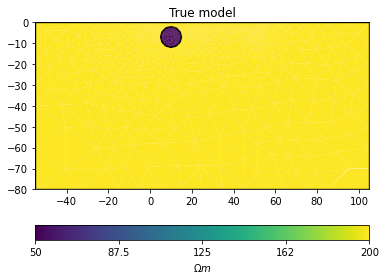

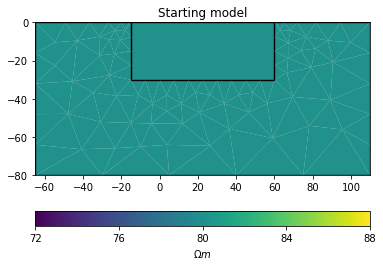

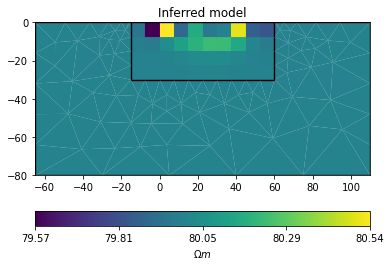

In [15]:
ax=pg.show(
    fmesh,
    data=(model_true),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pg.show(
    imesh,
    data=(model_0),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")


ax=pg.show(
    imesh,
    data=(inv_result.model),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model");

### 2.2 A custom [Newton's optimization](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) approach

Now we switch to a Newton's iterative approach written by ourselves, so you'll 
have a closer look at what's happening in the loop.

First of all, define our own solver.

In [16]:
from cofi.tools import BaseInferenceTool

class MyNewtonSolver(BaseInferenceTool):
    def __init__(self, inv_problem, inv_options):
        __params = inv_options.get_params()
        self._niter = __params["niter"]
        self._step = __params["step"]
        self._verbose = __params["verbose"]
        self._model_0 = inv_problem.initial_model
        self._gradient = inv_problem.gradient
        self._hessian = inv_problem.hessian
        self._misfit = inv_problem.data_misfit if inv_problem.data_misfit_defined else None
        self._reg = inv_problem.regularization if inv_problem.regularization_defined else None
        self._obj = inv_problem.objective if inv_problem.objective_defined else None
        
    def __call__(self):
        current_model = np.array(self._model_0)
        for i in range(self._niter):
            term1 = self._hessian(current_model)
            term2 = - self._gradient(current_model)
            model_update = np.linalg.solve(term1, term2)
            current_model = np.array(current_model + self._step * model_update)
            if self._verbose:
                print("-" * 80)
                print(f"Iteration {i+1}")
                if self._misfit: self._misfit(current_model)
                if self._reg: self._reg(current_model)
                # if self._obj: print("objective func:", self._obj(current_model))
        return {"model": current_model, "success": True}

Now, make use of this custom solver and run inversion again:

In [17]:
inv_options_own_solver = InversionOptions()
inv_options_own_solver.set_tool(MyNewtonSolver)
inv_options_own_solver.set_params(niter=100, step=1, verbose=True)

inv_own_solver = Inversion(ert_problem, inv_options_own_solver)
inv_own_solver_res = inv_own_solver.run()
inv_own_solver_res.summary()

--------------------------------------------------------------------------------
Iteration 1
data misfit: 1323.2573456559178
raw regularization: 94.16649894082313


--------------------------------------------------------------------------------
Iteration 2
data misfit: 1317.4272078955055
raw regularization: 229.48689013717413


--------------------------------------------------------------------------------
Iteration 3
data misfit: 1312.3875589366344
raw regularization: 369.5349248914501


--------------------------------------------------------------------------------
Iteration 4
data misfit: 1307.8671166847114
raw regularization: 516.2007891101815


--------------------------------------------------------------------------------
Iteration 5
data misfit: 1303.743319848044
raw regularization: 670.4903777355404


--------------------------------------------------------------------------------
Iteration 6
data misfit: 1299.9466685775733
raw regularization: 831.5091039759614


--------------------------------------------------------------------------------
Iteration 7
data misfit: 1296.4309036449204
raw regularization: 997.5082751621549


--------------------------------------------------------------------------------
Iteration 8
data misfit: 1293.1619801802674
raw regularization: 1166.564947628929


--------------------------------------------------------------------------------
Iteration 9
data misfit: 1290.1131651283702
raw regularization: 1336.9012543806984


--------------------------------------------------------------------------------
Iteration 10
data misfit: 1287.2625543857775
raw regularization: 1507.0007118095011


--------------------------------------------------------------------------------
Iteration 11
data misfit: 1284.591693811364
raw regularization: 1675.6273634992572


--------------------------------------------------------------------------------
Iteration 12
data misfit: 1282.0846663946704
raw regularization: 1841.80432178583


--------------------------------------------------------------------------------
Iteration 13
data misfit: 1279.7276120130646
raw regularization: 2004.778655836884


--------------------------------------------------------------------------------
Iteration 14
data misfit: 1277.5082531037153
raw regularization: 2163.984774114935


--------------------------------------------------------------------------------
Iteration 15
data misfit: 1275.415632666988
raw regularization: 2319.0109181653024


--------------------------------------------------------------------------------
Iteration 16
data misfit: 1273.4399159436578
raw regularization: 2469.5703704873267


--------------------------------------------------------------------------------
Iteration 17
data misfit: 1271.5721923267781
raw regularization: 2615.4773156080028


--------------------------------------------------------------------------------
Iteration 18
data misfit: 1269.8043374987653
raw regularization: 2756.6269571547095


--------------------------------------------------------------------------------
Iteration 19
data misfit: 1268.1289417129697
raw regularization: 2892.9792030316275


--------------------------------------------------------------------------------
Iteration 20
data misfit: 1266.5392238225425
raw regularization: 3024.545403047737


--------------------------------------------------------------------------------
Iteration 21
data misfit: 1265.0289364283803
raw regularization: 3151.37751396932


--------------------------------------------------------------------------------
Iteration 22
data misfit: 1263.5923681948116
raw regularization: 3273.5592070813727


--------------------------------------------------------------------------------
Iteration 23
data misfit: 1262.2242681382875
raw regularization: 3391.1986698867026


--------------------------------------------------------------------------------
Iteration 24
data misfit: 1260.9198190583863
raw regularization: 3504.422707849465


--------------------------------------------------------------------------------
Iteration 25
data misfit: 1259.6746257332445
raw regularization: 3613.371892392459


--------------------------------------------------------------------------------
Iteration 26
data misfit: 1258.4846472078373
raw regularization: 3718.1966520460646


--------------------------------------------------------------------------------
Iteration 27
data misfit: 1257.346207507833
raw regularization: 3819.054015763523


--------------------------------------------------------------------------------
Iteration 28
data misfit: 1256.2559586844648
raw regularization: 3916.1050169554833


--------------------------------------------------------------------------------
Iteration 29
data misfit: 1255.210868577878
raw regularization: 4009.5125623604645


--------------------------------------------------------------------------------
Iteration 30
data misfit: 1254.2081597163317
raw regularization: 4099.439756694675


--------------------------------------------------------------------------------
Iteration 31
data misfit: 1253.2453443402976
raw regularization: 4186.048463852567


--------------------------------------------------------------------------------
Iteration 32
data misfit: 1252.3201490414776
raw regularization: 4269.498298342918


--------------------------------------------------------------------------------
Iteration 33
data misfit: 1251.4305407140998
raw regularization: 4349.945702994137


--------------------------------------------------------------------------------
Iteration 34
data misfit: 1250.574682497917
raw regularization: 4427.54333431529


--------------------------------------------------------------------------------
Iteration 35
data misfit: 1249.7509301261464
raw regularization: 4502.439559775057


--------------------------------------------------------------------------------
Iteration 36
data misfit: 1248.957807664945
raw regularization: 4574.778105500306


--------------------------------------------------------------------------------
Iteration 37
data misfit: 1248.1939897585862
raw regularization: 4644.697777590396


--------------------------------------------------------------------------------
Iteration 38
data misfit: 1247.4583015505991
raw regularization: 4712.332310211289


--------------------------------------------------------------------------------
Iteration 39
data misfit: 1246.7496997615608
raw regularization: 4777.81030521444


--------------------------------------------------------------------------------
Iteration 40
data misfit: 1246.0672712998514
raw regularization: 4841.255106567284


--------------------------------------------------------------------------------
Iteration 41
data misfit: 1245.4102080196608
raw regularization: 4902.785133778231


--------------------------------------------------------------------------------
Iteration 42
data misfit: 1244.7778081703868
raw regularization: 4962.513412761691


--------------------------------------------------------------------------------
Iteration 43
data misfit: 1244.1694694937053
raw regularization: 5020.548115483562


--------------------------------------------------------------------------------
Iteration 44
data misfit: 1243.5846686358582
raw regularization: 5076.992490395878


--------------------------------------------------------------------------------
Iteration 45
data misfit: 1243.0229840382399
raw regularization: 5131.945013305603


--------------------------------------------------------------------------------
Iteration 46
data misfit: 1242.4840673692631
raw regularization: 5185.499547852593


--------------------------------------------------------------------------------
Iteration 47
data misfit: 1241.9676514856158
raw regularization: 5237.745462174916


--------------------------------------------------------------------------------
Iteration 48
data misfit: 1241.4735256296951
raw regularization: 5288.767828189368


--------------------------------------------------------------------------------
Iteration 49
data misfit: 1241.0015731710948
raw regularization: 5338.647505899438


--------------------------------------------------------------------------------
Iteration 50
data misfit: 1240.5517203363831
raw regularization: 5387.461383776531


--------------------------------------------------------------------------------
Iteration 51
data misfit: 1240.1239715767108
raw regularization: 5435.2824367936355


--------------------------------------------------------------------------------
Iteration 52
data misfit: 1239.7183987858548
raw regularization: 5482.179941080558


--------------------------------------------------------------------------------
Iteration 53
data misfit: 1239.3351141860242
raw regularization: 5528.21955437856


--------------------------------------------------------------------------------
Iteration 54
data misfit: 1238.9743044068607
raw regularization: 5573.463446786386


--------------------------------------------------------------------------------
Iteration 55
data misfit: 1238.636226317335
raw regularization: 5617.970429444151


--------------------------------------------------------------------------------
Iteration 56
data misfit: 1238.3211854352687
raw regularization: 5661.796043708688


--------------------------------------------------------------------------------
Iteration 57
data misfit: 1238.0295396868223
raw regularization: 5704.992654920632


--------------------------------------------------------------------------------
Iteration 58
data misfit: 1237.7617246207162
raw regularization: 5747.609490869385


--------------------------------------------------------------------------------
Iteration 59
data misfit: 1237.518224553857
raw regularization: 5789.692727231352


--------------------------------------------------------------------------------
Iteration 60
data misfit: 1237.2995835886802
raw regularization: 5831.285513420678


--------------------------------------------------------------------------------
Iteration 61
data misfit: 1237.106416893494
raw regularization: 5872.427999951246


--------------------------------------------------------------------------------
Iteration 62
data misfit: 1236.9393852099986
raw regularization: 5913.157346985135


--------------------------------------------------------------------------------
Iteration 63
data misfit: 1236.799228008771
raw regularization: 5953.507693002444


--------------------------------------------------------------------------------
Iteration 64
data misfit: 1236.6867356619125
raw regularization: 5993.510151103873


--------------------------------------------------------------------------------
Iteration 65
data misfit: 1236.6027519924746
raw regularization: 6033.192776170944


--------------------------------------------------------------------------------
Iteration 66
data misfit: 1236.5481995443847
raw regularization: 6072.580468497676


--------------------------------------------------------------------------------
Iteration 67
data misfit: 1236.5240500930722
raw regularization: 6111.694953766153


--------------------------------------------------------------------------------
Iteration 68
data misfit: 1236.5313320960033
raw regularization: 6150.554666664268


--------------------------------------------------------------------------------
Iteration 69
data misfit: 1236.5711642775805
raw regularization: 6189.172336561268


--------------------------------------------------------------------------------
Iteration 70
data misfit: 1236.6448302801516
raw regularization: 6227.548054872318


--------------------------------------------------------------------------------
Iteration 71
data misfit: 1236.7529503775118
raw regularization: 6265.732607108361


--------------------------------------------------------------------------------
Iteration 72
data misfit: 1236.8973084662332
raw regularization: 6303.69203098002


--------------------------------------------------------------------------------
Iteration 73
data misfit: 1237.079068246992
raw regularization: 6341.434992247178


--------------------------------------------------------------------------------
Iteration 74
data misfit: 1237.2995008273358
raw regularization: 6378.960001856105


--------------------------------------------------------------------------------
Iteration 75
data misfit: 1237.5599265993906
raw regularization: 6416.260788494526


--------------------------------------------------------------------------------
Iteration 76
data misfit: 1237.8616893623714
raw regularization: 6453.327126647611


--------------------------------------------------------------------------------
Iteration 77
data misfit: 1238.2061253998318
raw regularization: 6490.145070411092


--------------------------------------------------------------------------------
Iteration 78
data misfit: 1238.5945754293048
raw regularization: 6526.6970673798505


--------------------------------------------------------------------------------
Iteration 79
data misfit: 1239.0283176285038
raw regularization: 6562.962192582712


--------------------------------------------------------------------------------
Iteration 80
data misfit: 1239.5086471977936
raw regularization: 6598.916301143818


--------------------------------------------------------------------------------
Iteration 81
data misfit: 1240.0367318523604
raw regularization: 6634.532389504962


--------------------------------------------------------------------------------
Iteration 82
data misfit: 1240.6137102202263
raw regularization: 6669.78087293904


--------------------------------------------------------------------------------
Iteration 83
data misfit: 1241.2405959717282
raw regularization: 6704.63007274389


--------------------------------------------------------------------------------
Iteration 84
data misfit: 1241.9182802608705
raw regularization: 6739.046608601495


--------------------------------------------------------------------------------
Iteration 85
data misfit: 1242.6475029134663
raw regularization: 6772.995985148286


--------------------------------------------------------------------------------
Iteration 86
data misfit: 1243.42886049963
raw regularization: 6806.443123437915


--------------------------------------------------------------------------------
Iteration 87
data misfit: 1244.2627172681034
raw regularization: 6839.35294578632


--------------------------------------------------------------------------------
Iteration 88
data misfit: 1245.1492518230011
raw regularization: 6871.691130908705


--------------------------------------------------------------------------------
Iteration 89
data misfit: 1246.0883814332344
raw regularization: 6903.424247452236


--------------------------------------------------------------------------------
Iteration 90
data misfit: 1247.0797620596704
raw regularization: 6934.521094342216


--------------------------------------------------------------------------------
Iteration 91
data misfit: 1248.1227953441298
raw regularization: 6964.9525959812245


--------------------------------------------------------------------------------
Iteration 92
data misfit: 1249.216507714155
raw regularization: 6994.6925748119165


--------------------------------------------------------------------------------
Iteration 93
data misfit: 1250.359654645341
raw regularization: 7023.718123603567


--------------------------------------------------------------------------------
Iteration 94
data misfit: 1251.5506503945035
raw regularization: 7052.009956406449


--------------------------------------------------------------------------------
Iteration 95
data misfit: 1252.787568509757
raw regularization: 7079.552700395352


--------------------------------------------------------------------------------
Iteration 96
data misfit: 1254.0680744779243
raw regularization: 7106.334961674689


--------------------------------------------------------------------------------
Iteration 97
data misfit: 1255.3894834525918
raw regularization: 7132.349486334322


--------------------------------------------------------------------------------
Iteration 98
data misfit: 1256.7488335633086
raw regularization: 7157.5931411202755


--------------------------------------------------------------------------------
Iteration 99
data misfit: 1258.1426878822476
raw regularization: 7182.066751832764


--------------------------------------------------------------------------------
Iteration 100
data misfit: 1259.56737217134
raw regularization: 7205.775016190504
Summary for inversion result
SUCCESS
----------------------------
model: [ 63.61648633  60.29172601  61.12599476  69.3473942   60.67674565
  66.36502945  54.01871578  55.35067806  72.09483801  66.68772713
  68.72184338  75.78734297  71.741809    85.96123189  56.7010638
  81.09080721  57.58088289  84.06437425  74.41950897  62.18759573
  75.27193246  61.46587917  58.31097681  51.91240561  55.15048743
  53.91854651  64.29736971  63.26477336  79.83370423  52.23184409
  76.08011925  48.93715612  47.92933449  72.22032984  55.27158642
  74.09388419  50.49803601  56.12816353  53.36644865  48.36818774
  67.47743852  53.29464229  79.10502963  56.9757056   64.18722588
  65.84217937  53.26148556  81.46539386  52.35213984  84.14532912
  57.78295865  63.4445566   85.17296795  53.87867845  82.17943381
  55.57136785  53.44174645  82.30587244

Plot the results:

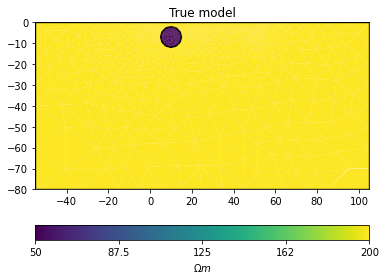

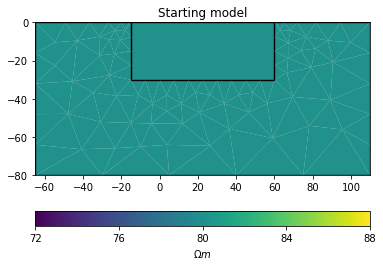

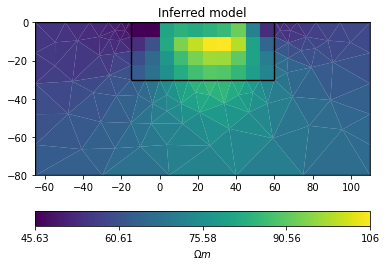

In [18]:
ax=pg.show(
    fmesh,
    data=(model_true),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pg.show(
    imesh,
    data=(model_0),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")


ax=pg.show(
    imesh,
    data=(inv_own_solver_res.model),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model");

### 2.3 Bayesian sampling with emcee (exploration)

CoFI needs more assumptions about the problem for a sampler to work - these are
the log of posterior distribution density and walkers' starting positions.

For the log posterior, we define here by specifying `log_prior` and `log_likelihood`.
And CoFI will combine them to get the `log_posterior`.

In [19]:
# hyperparameters
nwalkers = 32
nsteps = 10

# define log_likelihood
sigma = 1.0                                     # common noise standard deviation
Cdinv = np.eye(len(y_obs))/(sigma**2)           # inverse data covariance matrix
def log_likelihood(model):
    residual = ert_problem.residual(model)
    return -0.5 * residual @ (Cdinv @ residual).T

# define log_prior
m_lower_bound = np.zeros(model_0.shape)         # lower bound for uniform prior
m_upper_bound = np.ones(model_0.shape) * 250    # upper bound for uniform prior
def log_prior(model):                           # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

# define walkers' starting positions
walkers_start = model_0 + 1e-6 * np.random.randn(nwalkers, model_0.shape[0])

# define them into cofi's BaseProblem object
ert_problem.set_log_likelihood(log_likelihood)
ert_problem.set_log_prior(log_prior)
ert_problem.set_walkers_starting_pos(walkers_start)

As usual, specify how you'd like to run the inversion and run it.

In [20]:
# define inversion options
inv_options_emcee = InversionOptions()
inv_options_emcee.set_tool("emcee")
inv_options_emcee.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True)

from emcee.moves import GaussianMove
inv_options_emcee.set_params(moves=GaussianMove(1))

# run the inversion
inv_rect_emcee = Inversion(ert_problem, inv_options_emcee)
inv_rect_emcee_res = inv_rect_emcee.run()


  0%|                                                                                                    | 0/10 [00:00<?, ?it/s]


 10%|█████████▏                                                                                  | 1/10 [00:09<01:23,  9.26s/it]


 20%|██████████████████▍                                                                         | 2/10 [00:20<01:21, 10.22s/it]


 30%|███████████████████████████▌                                                                | 3/10 [00:30<01:12, 10.33s/it]


 40%|████████████████████████████████████▊                                                       | 4/10 [00:39<00:57,  9.59s/it]


 50%|██████████████████████████████████████████████                                              | 5/10 [00:49<00:48,  9.77s/it]


 60%|███████████████████████████████████████████████████████▏                                    | 6/10 [00:59<00:39,  9.87s/it]


 70%|████████████████████████████████████████████████████████████████▍                           | 7/10 [01:09<00:29,  9.89s/it]


 80%|█████████████████████████████████████████████████████████████████████████▌                  | 8/10 [01:19<00:20, 10.02s/it]


 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 9/10 [01:30<00:10, 10.20s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.99s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.96s/it]

Let's sub-sample 10 models from the posterior ensemble and plot them out.

You'll see that the results are not as good. That's because we've used only 32 walkers
and 10 sampling steps.

In [21]:
sampler = inv_rect_emcee_res.sampler

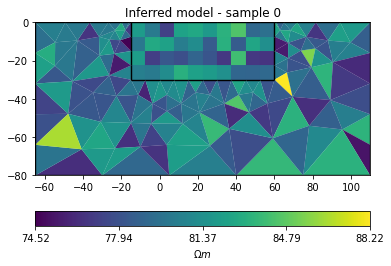

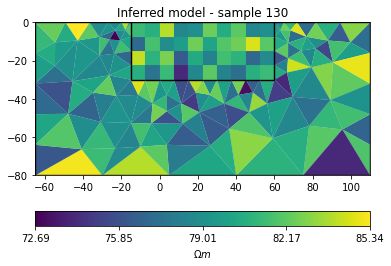

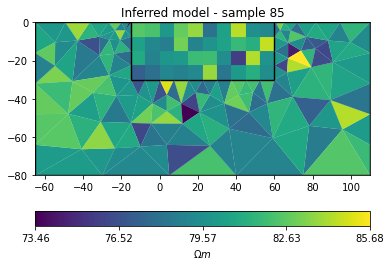

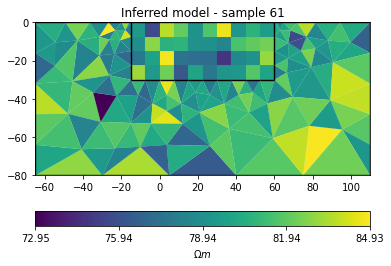

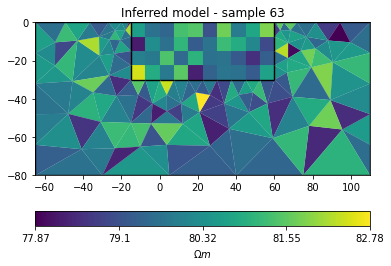

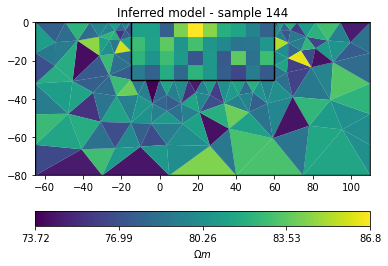

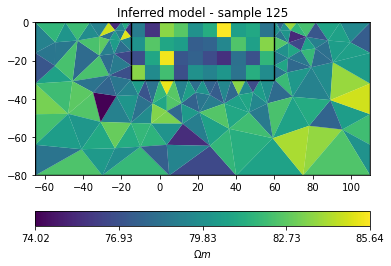

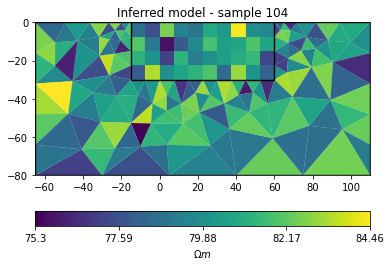

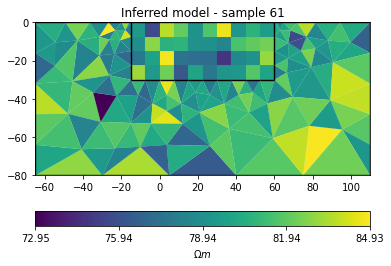

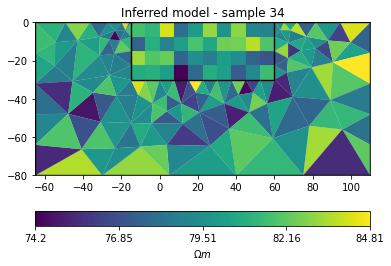

In [22]:
flat_samples = sampler.get_chain(discard=5, flat=True)
indices = np.random.randint(len(flat_samples), size=10) # get a random selection from posterior ensemble
for idx in indices:
    ax=pg.show(
        imesh,
        data=(flat_samples[idx]),
        label=r"$\Omega m$"
    )
    ax[0].set_title(f"Inferred model - sample {idx}");

Not satisfied with the results? Go back to the code cell under 2.3 and try with bigger numbers
of walkers and steps 😉

---
## Watermark

In [23]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev6
numpy 1.21.6
scipy 1.8.1
pygimli 1.2.6
matplotlib 3.5.2
emcee 3.1.2
arviz 0.12.1
